<a href="https://colab.research.google.com/github/DmitriiGoro/ML_2024_3_term/blob/master/LabWorks/lab02_part2_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)
len(fmnist_dataset_train)


In [ ]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    # num_classes - это количество классов, которые мы предсказываем
    # input_channels - например, ч/б изображения имеют 1 канал, цветные имеют 3 канала
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
       BatchNorm1d-8                  [-1, 128]             256
            Linear-9                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.90
Estimated Total Size (MB): 0.92
-------------------------------------------

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)

        loss.backward()
        opt.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/30], Loss: 0.6247, Train Acc: 0.7992, Test Acc: 0.8323
Epoch [2/30], Loss: 0.4330, Train Acc: 0.8487, Test Acc: 0.8497
Epoch [3/30], Loss: 0.3954, Train Acc: 0.8600, Test Acc: 0.8477
Epoch [4/30], Loss: 0.3649, Train Acc: 0.8711, Test Acc: 0.8632
Epoch [5/30], Loss: 0.3510, Train Acc: 0.8744, Test Acc: 0.8677
Epoch [6/30], Loss: 0.3366, Train Acc: 0.8780, Test Acc: 0.8670
Epoch [7/30], Loss: 0.3249, Train Acc: 0.8833, Test Acc: 0.8720
Epoch [8/30], Loss: 0.3164, Train Acc: 0.8848, Test Acc: 0.8767
Epoch [9/30], Loss: 0.3070, Train Acc: 0.8873, Test Acc: 0.8712
Epoch [10/30], Loss: 0.2974, Train Acc: 0.8916, Test Acc: 0.8769
Epoch [11/30], Loss: 0.2909, Train Acc: 0.8936, Test Acc: 0.8670
Epoch [12/30], Loss: 0.2860, Train Acc: 0.8949, Test Acc: 0.8759
Epoch [13/30], Loss: 0.2805, Train Acc: 0.8962, Test Acc: 0.8806
Epoch [14/30], Loss: 0.2753, Train Acc: 0.8990, Test Acc: 0.8805
Epoch [15/30], Loss: 0.2673, Train Acc: 0.9025, Test Acc: 0.8821
Epoch [16/30], Loss: 0.2620, Train

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 412),
            nn.ReLU(),
            nn.Linear(412, 312),
            nn.ReLU(),
            nn.Linear(312, 296),
            nn.ReLU(),
            nn.Linear(296, 254),
            nn.ReLU(),
            nn.Linear(254, 224),
            nn.ReLU(),
            nn.Linear(224, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        return self.model(inp)


In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 412]         323,420
              ReLU-3                  [-1, 412]               0
            Linear-4                  [-1, 312]         128,856
              ReLU-5                  [-1, 312]               0
            Linear-6                  [-1, 296]          92,648
              ReLU-7                  [-1, 296]               0
            Linear-8                  [-1, 254]          75,438
              ReLU-9                  [-1, 254]               0
           Linear-10                  [-1, 224]          57,120
             ReLU-11                  [-1, 224]               0
           Linear-12                  [-1, 128]          28,800
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [ ]:
from torch.utils.data import Subset, DataLoader

fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)

train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

train_loader_reduced = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_dataset_train, range(250)), batch_size=64, shuffle=True)



Epoch [1/100], Loss: 2.3059, Train Acc: 9.2000, Test Acc: 10.0000
Epoch [2/100], Loss: 2.2918, Train Acc: 11.6000, Test Acc: 17.4000
Epoch [3/100], Loss: 2.2171, Train Acc: 20.0000, Test Acc: 21.7400
Epoch [4/100], Loss: 1.9376, Train Acc: 22.8000, Test Acc: 19.3400
Epoch [5/100], Loss: 1.6697, Train Acc: 24.8000, Test Acc: 43.6900
Epoch [6/100], Loss: 1.5020, Train Acc: 36.0000, Test Acc: 46.6500
Epoch [7/100], Loss: 1.3568, Train Acc: 46.4000, Test Acc: 39.9500
Epoch [8/100], Loss: 1.2468, Train Acc: 44.8000, Test Acc: 52.2600
Epoch [9/100], Loss: 1.1292, Train Acc: 54.4000, Test Acc: 49.6000
Epoch [10/100], Loss: 1.1500, Train Acc: 54.8000, Test Acc: 54.7000
Epoch [11/100], Loss: 1.0445, Train Acc: 53.2000, Test Acc: 53.2100
Epoch [12/100], Loss: 0.9602, Train Acc: 57.2000, Test Acc: 53.1700
Epoch [13/100], Loss: 0.9161, Train Acc: 58.0000, Test Acc: 54.8300
Epoch [14/100], Loss: 0.9461, Train Acc: 60.8000, Test Acc: 57.0300
Epoch [15/100], Loss: 0.8140, Train Acc: 63.2000, Test Acc

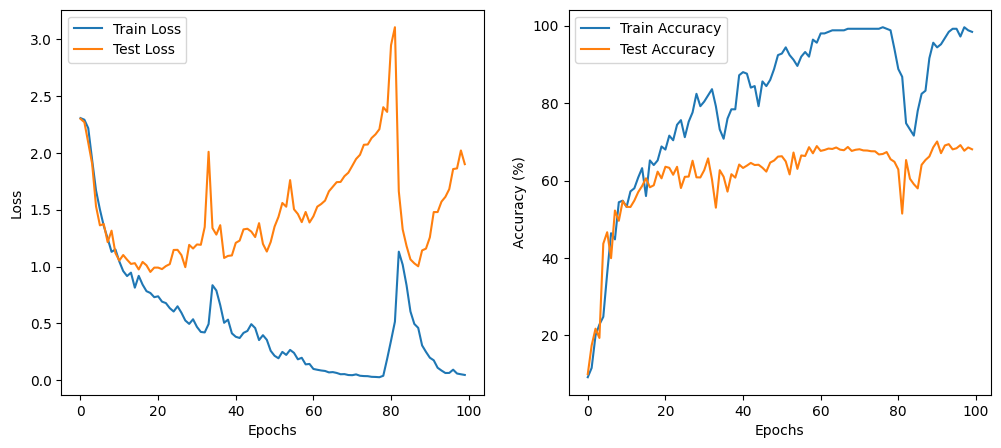

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim

def train_model(model, train_loader, test_loader, epochs=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / len(test_loader)
        test_accuracy = 100.0 * correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

model = OverfittingNeuralNetwork(input_shape=28*28, num_classes=10).to(device)
train_model(model, train_loader_reduced, test_loader, epochs=100)


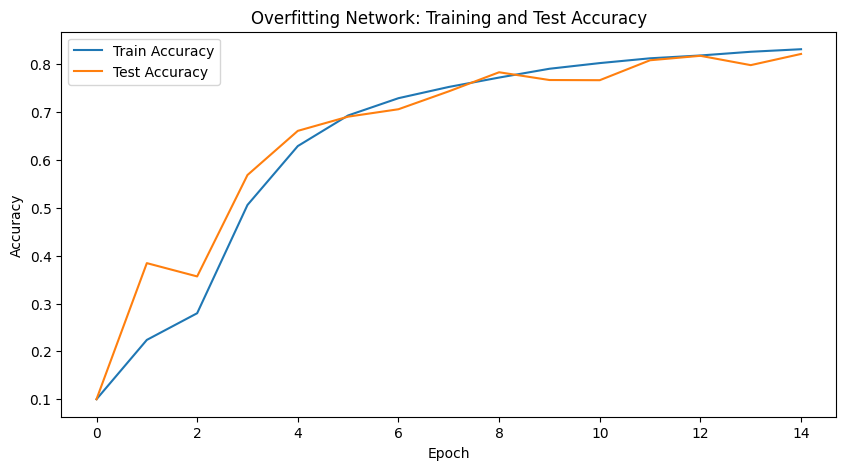

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_overfit, label='Train Accuracy')
plt.plot(test_accuracies_overfit, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Overfitting Network: Training and Test Accuracy')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 412),
            nn.ReLU(),
            nn.BatchNorm1d(412),
            nn.Linear(412, 312),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(312, 296),
            nn.ReLU(),
            nn.Linear(296, 254),
            nn.ReLU(),
            nn.Linear(254, 224),
            nn.ReLU(),
            nn.Linear(224, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 2048]       8,390,656
       BatchNorm1d-6                 [-1, 2048]           4,096
              ReLU-7                 [-1, 2048]               0
            Linear-8                 [-1, 1024]       2,098,176
       BatchNorm1d-9                 [-1, 1024]           2,048
             ReLU-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
      BatchNorm1d-12                  [-1, 512]           1,024
             ReLU-13                  [-1, 512]               0
           Linear-14                  [

Epoch [1/100], Loss: 2.2953, Train Acc: 18.0000, Test Acc: 23.1800
Epoch [2/100], Loss: 2.2288, Train Acc: 41.2000, Test Acc: 30.0500
Epoch [3/100], Loss: 1.9276, Train Acc: 48.0000, Test Acc: 39.2000
Epoch [4/100], Loss: 1.4020, Train Acc: 46.0000, Test Acc: 41.7200
Epoch [5/100], Loss: 1.1000, Train Acc: 55.6000, Test Acc: 50.0700
Epoch [6/100], Loss: 0.8633, Train Acc: 64.4000, Test Acc: 54.5000
Epoch [7/100], Loss: 0.7455, Train Acc: 68.4000, Test Acc: 61.7900
Epoch [8/100], Loss: 0.5762, Train Acc: 79.6000, Test Acc: 62.4400
Epoch [9/100], Loss: 0.4429, Train Acc: 84.4000, Test Acc: 63.9600
Epoch [10/100], Loss: 0.3320, Train Acc: 90.8000, Test Acc: 70.5100
Epoch [11/100], Loss: 0.2589, Train Acc: 92.4000, Test Acc: 69.9100
Epoch [12/100], Loss: 0.2569, Train Acc: 90.8000, Test Acc: 69.3000
Epoch [13/100], Loss: 0.2047, Train Acc: 91.6000, Test Acc: 65.1900
Epoch [14/100], Loss: 0.1276, Train Acc: 96.4000, Test Acc: 70.8200
Epoch [15/100], Loss: 0.0994, Train Acc: 96.8000, Test Ac

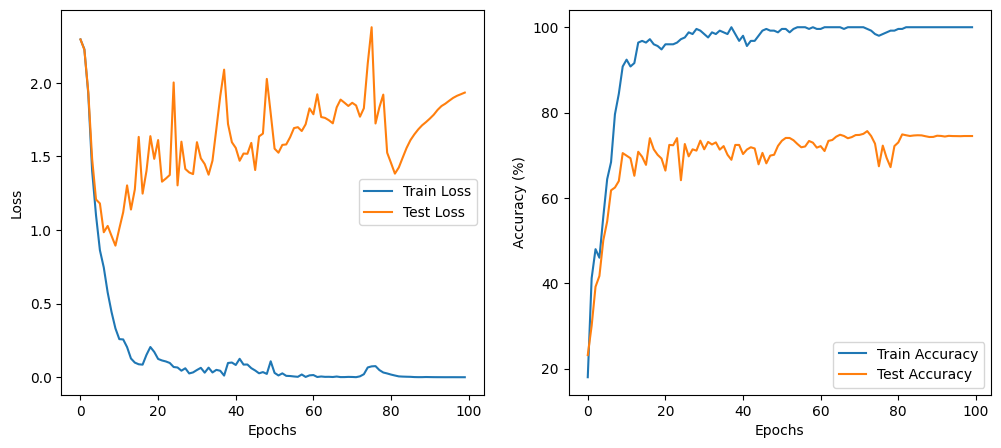

In [ ]:
def train_model(model, train_loader, test_loader, epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100.0 * correct_train / total_train

        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / len(test_loader)
        test_accuracy = 100.0 * correct_test / total_test

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

model = FixedNeuralNetwork(input_shape=28*28, num_classes=10).to(device)
train_model(model, train_loader_reduced, test_loader, epochs=100)

### Conclusions:
_Write down small report with your conclusions and your ideas._

Согласно теории, существуют различные методы предотвращения переобучения модели. Например, BatchNormalization, DropOut и другие. Следовательно отсутствие данных методов повышает вероятность переобучения. Также одной из причин переобучения модели может являться усложненная архитектура модели.
В моем случае, проведя несколько десятков экспериментов с использованием сложной модели с большим количеством параметром модель так и не переобучилась. Что говорит о том, что не всегда сложная модель с отсутствием регуляризации переобучается на "простых" для нее данных.
Однако, в ходе анализа разных архитектур выяснилось, что добавление BatchNormalization и DropOut на 2 слоя помогает повысить точность модели до 7%
.